# Transfer Learning

In [1]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
!pwd

import json, sys, os
from utils import checkLocalServer, Config_Manager

cfgm = Config_Manager()
cfgm.set_cfg_path('./configs/config_model.json')
cfg = cfgm.get_cfg()
cfgm.print()

checkLocalServer(cfg['isLocalServer'])

/notebook


ModuleNotFoundError: No module named 'utils'

image size: 250
0 jhoh
1 jhongyoo
2 jhyoo
3 kschoi
batch_size: 2 

dataset length: (20) = tr (16) + val (2) + tt (2)
image dimension: (3, 250, 250)


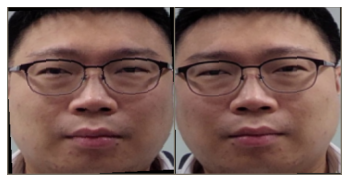

input shape: torch.Size([3, 250, 250]) / label shape: torch.Size([]) / label: 3
input shape: torch.Size([3, 250, 250]) / label shape: torch.Size([]) / label: 0
input shape: torch.Size([3, 250, 250]) / label shape: torch.Size([]) / label: 0
input shape: torch.Size([3, 250, 250]) / label shape: torch.Size([]) / label: 2


In [3]:
from datasets import Folder_Dataset
from utils import imshow_dataloader

folder_Dataset = Folder_Dataset(cfg['data'])

dataloaders, dataset_sizes, idx_to_class = folder_Dataset.createDataLoaders()

# show a example picture 
image_size = imshow_dataloader(dataloaders["train"])

phase="train"
for i, (inputs, labels) in enumerate(dataloaders[phase]):
  if i > 3:
    break
  print(f'input shape: {inputs[0].shape} / label shape: {labels[0].shape} / label: {labels[0]}')
  

In [23]:
# test_dataset = folder_Dataset.getDataset()


# from datasets import splitDatasetBasedOnSelection, NumpyBaseDataset, build_dataloader
# selected_numpy, unselected_numpy = splitDatasetBasedOnSelection(test_dataset,
#                                                                 unselected_labels = [3])

    
# selected_dataset = NumpyBaseDataset(cfg['NumpyBaseDataset'], selected_numpy)
# unselected_dataset = NumpyBaseDataset(cfg['NumpyBaseDataset'], unselected_numpy)

# len(selected_dataset)

# unselected_dataloader = build_dataloader(cfg['build_dataloader'], False, unselected_dataset)
# selected_dataloaders, selected_dataset_sizes = build_dataloader(cfg['build_dataloader'], True, selected_dataset)


dataset length: (15) = tr (12) + val (1) + tt (2)


# Train model

In [24]:
from modules import Builder
import torch.nn as nn
import torch.optim as optim

builder = Builder(cfg['model'])
builder.summary()
model = builder.getModel()

# declaration for learning and testing|
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

device is cpu
Loading model was just completed.
InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_st

In [26]:
from modules import runner
phases = ['train', 'val']

model, train_evaluation_matrix, val_evaluation_matrix = runner(model, phases, criterion, optimizer, scheduler, selected_dataloaders, selected_dataset_sizes, num_epochs=30)

Epoch 0/29
[phase]:train
torch.Size([2, 3, 250, 20833]) tensor([2, 2])


KeyboardInterrupt: 

30 4


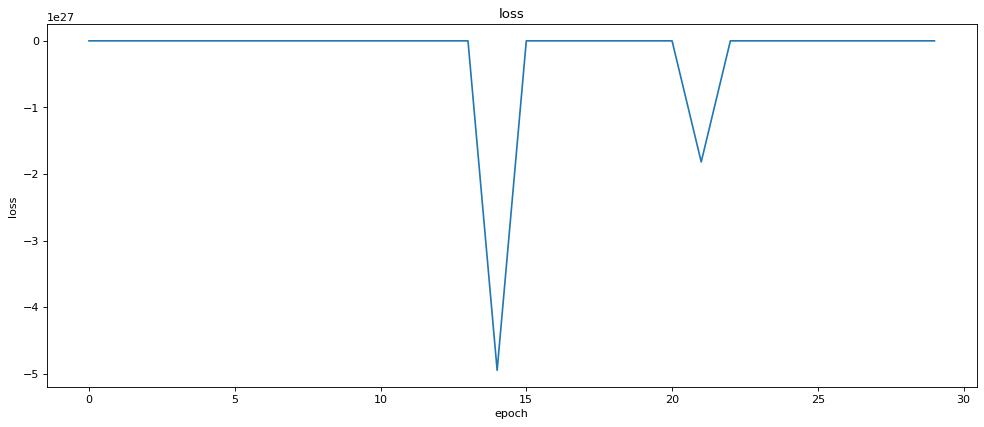

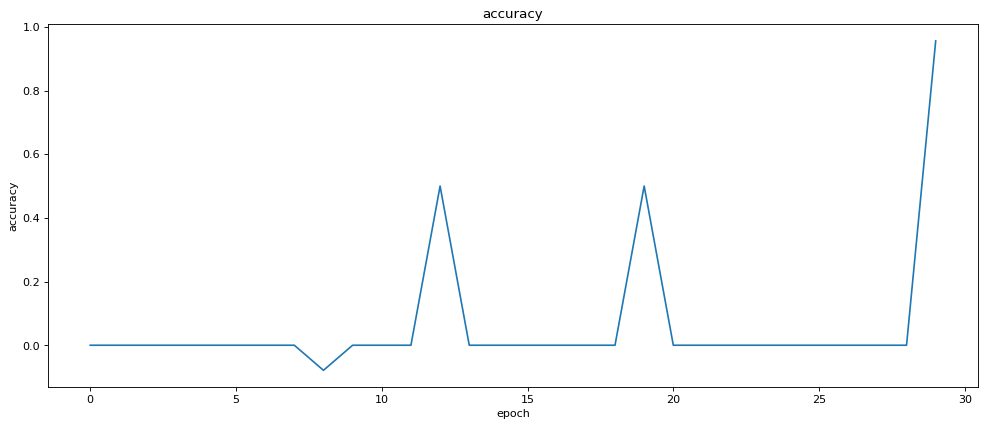

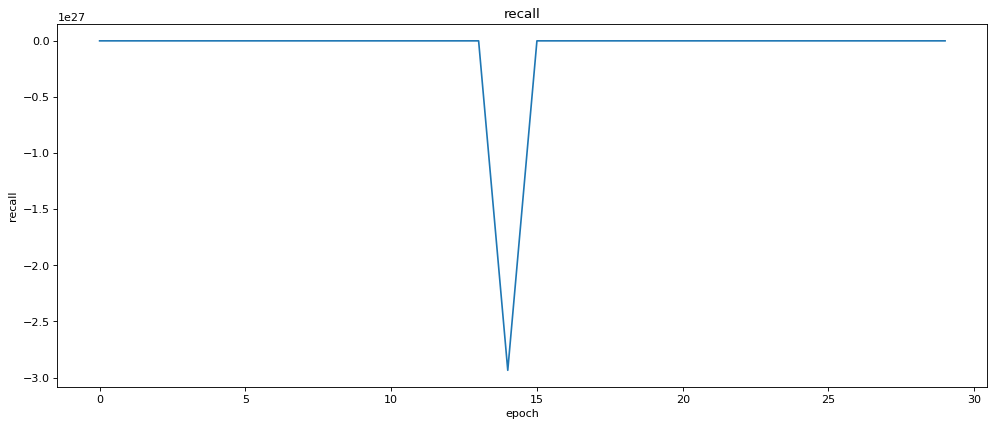

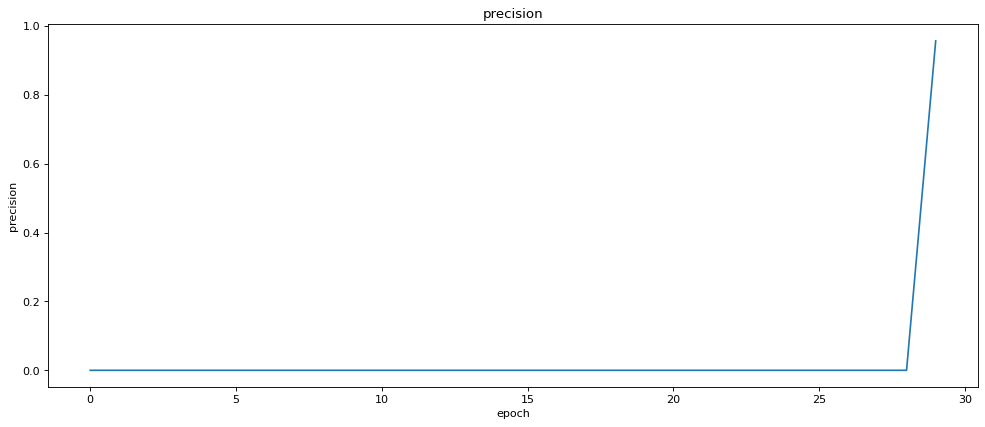

In [22]:
import matplotlib.pyplot as plt
train_evaluation_numpy = train_evaluation_matrix.to('cpu').numpy()
val_evaluation_numpy = val_evaluation_matrix.to('cpu').numpy()

num_epochs, num_evaluations = train_evaluation_numpy.shape
print(num_epochs, num_evaluations)

title_list = ['loss', 'accuracy', 'recall', 'precision']
for col, title in zip(range(0, num_evaluations), title_list):
  plt.figure(figsize=(15, 6), dpi=80)
  plt.title(title)
  plt.ylabel(title)
  plt.xlabel('epoch')
  plt.plot(range(0, num_epochs), train_evaluation_numpy[:, col])
  plt.show()

In [24]:
phases = ['test']
runner(model, phases, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=1)

Epoch 0/0
test Loss: 0.0210 Acc: 1.0000 recall: 1.0000 Precision: 1.0000
----------------------------------------------------------------------------------------------------
Training complete in 0m 0s
Best val Acc: 0.000000
there is no return value becasue of test mode


## Save trained model

In [29]:
import torch
cfg = cfgm.get_cfg()
path_for_saving_model = cfg['path_for_saving_model']

try: 
  torch.save(model.state_dict(), path_for_saving_model)
  print(f'successfully saved model in {path_for_saving_model}')
except:
  print(f'failed saving model in {path_for_saving_model}')

successfully saved model in ./data/face-extraction-model.pt


# [TEST] face_feature_extractor with trained classifier(last layer)

In [11]:
phases = ['test']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for phase in phases:
  for i, (inputs, labels) in enumerate(dataloaders[phase]):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    print('outputs before softmax:', outputs)
    outputs = F.softmax(outputs)
    print('outputs after softmax:', outputs)
    values, preds = torch.max(outputs, 1)
    print(values)
    
    
    print('\n')
    if i > 2:
      break
    

outputs before softmax: tensor([[ 0.8738, -0.0816, -0.0971, -0.1739],
        [ 2.6717, -1.2313, -0.5616, -0.2554],
        [ 0.6973, -0.7312, -0.7267, -0.6467],
        [ 0.4991, -0.6614, -0.6663, -0.4693]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
outputs after softmax: tensor([[0.4730, 0.1820, 0.1792, 0.1659],
        [0.8983, 0.0181, 0.0354, 0.0481],
        [0.5743, 0.1376, 0.1383, 0.1498],
        [0.4988, 0.1563, 0.1555, 0.1894]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([0.4730, 0.8983, 0.5743, 0.4988], device='cuda:0',
       grad_fn=<MaxBackward0>)


outputs before softmax: tensor([[ 0.6822, -0.6297, -0.5278, -0.2998],
        [ 0.5660, -0.3563, -0.1779, -0.1523],
        [ 0.6837, -0.2881, -0.3099, -0.5664],
        [ 1.4737, -0.6912, -0.7532, -0.6761]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
outputs after softmax: tensor([[0.5149, 0.1387, 0.1535, 0.1929],
        [0.4236, 0.1684, 0.2013, 0.2066],
        [0.4914, 0.1859, 0.1819, 0.1408]